In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
## define functions
# compute confidence based on recency of memory/reward received
def make_pvals(p, envelope):
    return 1/np.cosh(p/envelope)

# retrieve relevant items from memory
def cosine_sim(key, dictionary, **kwargs):
    similarity_threshold = kwargs.get('threshold', 0.9)

    mem_cache = np.asarray(list(dictionary.keys()))
    entry     = np.asarray(key)

    mqt     = np.dot(mem_cache, entry)
    norm    = np.linalg.norm(mem_cache, axis = 1) * np.linalg.norm(entry) 

    cosine_similarity = mqt/norm

    if max(cosine_similarity) >= similarity_threshold:
        index = np.argmax(cosine_similarity)
        similar_activity = mem_cache[index]
        return similar_activity, index

    else:
        #print('max memory similarity:', max(cosine_similarity))
        return [],[]
    
def make_cs(rwd, **kwargs):
    envelope = kwargs.get('envelope',10)
    tslr = []
    time_since_last_reward = np.nan 
    for i in rwd:
        tslr.append(time_since_last_reward)
        if i == 0:
            time_since_last_reward +=1
        if i == 1:
            time_since_last_reward = 0
            
    return make_pvals(np.asarray(tslr), envelope=envelope)


# make dummy list of rewards received
def make_spikelist(alpha):
    return np.random.choice([0,1], 100, p=[1-alpha,alpha])

# make dummy dictionary 
def make_dict(length, **kwargs):
    key_length = kwargs.get('key_length', 50)
    mem_length = kwargs.get('mem_length', length*10)
    d = {}
    for i in range(length):
        #make dict key
        k = tuple(np.random.choice(np.arange(10),key_length))
        timestamp = np.random.randint(0, mem_length)
        deltaval = np.random.randn()
        d[k] = timestamp, deltaval
    return d


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in cosh
  after removing the cwd from sys.path.


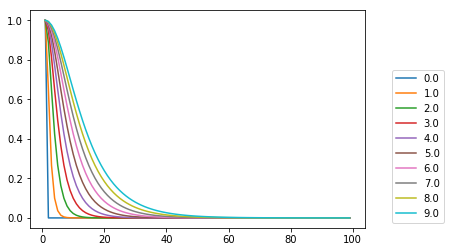

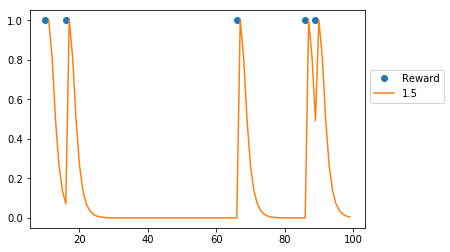

In [3]:
## MFC confidence score tests

## Plot showing different confidence score decay envelopes
test = np.zeros(100)
test[0]= 1

plt.figure()
for i in range(10):
    env = i+ 0.001
    cs = make_cs(test,envelope=env)
    #print(i, np.where(cs<0.01)[0][0]) #how many steps before cs reaches zero
    plt.plot(cs,label=f'{np.round(env,1)}')
plt.legend(bbox_to_anchor = (1.25,.75))
plt.show()
plt.close()

### plot showing decay after randomly distributed rewards
reward_frequency = 0.1
cs_envelope = 1.5

sl = make_spikelist(reward_frequency)
sl1 = np.where(sl==1)[0]

cs = make_cs(sl,envelope=cs_envelope)

plt.figure()
plt.plot(sl1, np.ones_like(sl1) ,'o', label='Reward')
plt.plot(cs,label=f'{np.round(cs_envelope,1)}')
plt.legend(bbox_to_anchor = (1.25,.75))
plt.show()
plt.close()

In [6]:
## Test dictionary for memory confidence tests
## show confidence in a dictionary entry
key_length = 10
dic_length = 50
num_sample = 1000

d = make_dict(dic_length, key_length=key_length)
pn = {}
js = [1.5/cs_envelope]
for j in js:#range(1,11):
    pn[str(j)] = [[],[],[]]
    #d = make_dict(dic_length, key_length=key_length)
    for i in range(num_sample): 
        test_key = tuple(np.random.choice(np.arange(10), key_length))
        sim_key, index = cosine_sim(test_key, d)

        if len(sim_key) is not 0:
            envelope = cs_envelope*j*10
            timestamp, deltavalue = d[tuple(sim_key)]
            confidence = make_pvals(timestamp, envelope)
            delta_scaled_conf = deltavalue*make_pvals(timestamp, envelope)
            pn[str(j)][0].append(timestamp)
            pn[str(j)][1].append(confidence)
            pn[str(j)][2].append(delta_scaled_conf)
        else:
            pass

255
279
255
453
108
108
78
451
51
219
405
51
121
219
255
53
103
375
219
215
215
108
473
457
51
462
121
279
480
51
253
220
405
188
405
138
103
462
451
451
136
182
201
457
469
464
255
138
103
220
138
2
473
219
453
108
208
364
138
321
257
51
188
68
138
182
253
103
103
68
364
462
138
405
255
464
473
279
51
220
321
220
51
19
321
108
255
51
188
103
464
103
257
53
103
497
321
182
188
364
172
220
486
279
464
285
453
464
462
136
480
208
375
480
53
460
364
220
405
473
285
2
464
405
136
253
121
321
121
497
453
255
497
497
253
188
172
285
108
51
208
138
253
405
220
136
422
136
464
487
136
255
464
103
497
51
136
188
364
215
464
457
464
51
138
375
172
375
375
220
473
453
497
138
321
103
172
53
108
103
321
172
51
108
460
53
462
51
172
201
497
121
69
460
255
457
53
103
480
451
103
53
172
69
188
172
321
462
69
253
53
375
422
375
462
286
108
103
17
464
103
480
108
121
255
2
462
253
108
108
208
53
220
286
451
108
462
451
453
255
68
136
480
68
462
108
69
68
103
247
480
53
51
279
464
108
136
255
136
78
103

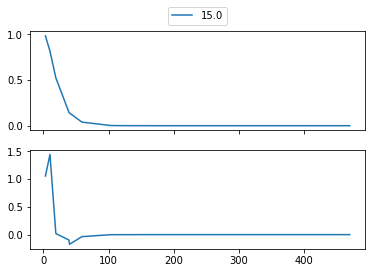

In [5]:
fig, ax = plt.subplots(2,1,sharex=True)

for j in js:
    label = f'{cs_envelope*j*10}'

    #ax[0].scatter(pn[str(j)][0], pn[str(j)][1], label=label)
    #ax[1].scatter(pn[str(j)][0], pn[str(j)][2], label=label)
    
    # plot time-dependent confidence
    test = zip(pn[str(j)][0], pn[str(j)][1])
    sort_test = sorted(test, key = lambda x: x[0])
    ax[0].plot(np.array(sort_test)[:,0], np.array(sort_test)[:,1], label=label)
    
    # plot delta-scaled confidence
    test = zip(pn[str(j)][0], pn[str(j)][2])
    sort_test = sorted(test, key = lambda x: x[0])
    ax[1].plot(np.array(sort_test)[:,0], np.array(sort_test)[:,1], label=label)
    
    
ax[0].legend(loc='upper center', bbox_to_anchor=(.5,1.3), ncol =3)
plt.show()
plt.close()

[[nan  0.]
 [nan  0.]
 [10.  2.]
 [nan  0.]
 [ 1. -4.]
 [nan  0.]]
[0 1 2 3 4 5]


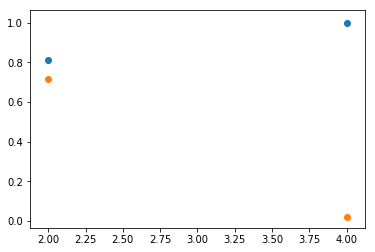

In [35]:
a = np.empty((6,2))
a[:,0] = np.nan
a[:,1] = 0 
a[2] = [10, 2]
a[4] = [1, -4]
print(a)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
x = make_pvals(a[:,0], 15)

print(np.arange(len(x)))

plt.figure()
plt.scatter(np.arange(len(x)), x)
plt.scatter(np.arange(len(x)), np.multiply(x, sigmoid(a[:,1])))

In [ ]:
# need to create arbitrator to decide between confidence of MFC and EC
''' 
option 1: softmax MF_cs and EC_cs 
    use this as a probability distribution to select either MF or EC

# pros:
 don't have to worry about convex combinations in nonconvex spaces 
# cons:
    20% certainty is not good, you want to heavily favour 80% confidence? 

option 2: combine pi_mf and pi_ec weighted by their respective cs scores
# pros:

# cons: 
'''


In [ ]:
## test how long a cosine similarity calculation takes for different key lengths
num_runs = 40
key_length = 100 # len(list(d.keys())[0])
d = make_dict(50, key_length = key_length)
avg_h = 0
for i in range(num_runs):
    test_key = tuple(np.random.choice(np.arange(10), key_length))
    start_time = time.time()
    cosine_sim(test_key, d)
    avg_h += time.time()-start_time
print(f'average run time is {avg_h/num_runs}')